In [133]:
import tensorflow as tf
import json
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
# Path to image file 
images = tf.data.Dataset.list_files("C:\\Users\\Connor\\Desktop\\Hard Hat Recongnition\\data\\images_pruned\\*.png", shuffle=False)
# Checks image path is corrrect
images.as_numpy_iterator().next()

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: C:\\Users\\Connor\\Desktop\\Hard Hat Recongnition\\data\\images_pruned\\*.png'

In [134]:
# Load a PNG image from the given file path and return a decoded image tensor
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_png(byte_img)
    img = tf.image.resize(img, [410, 410]) # So all imgs are same size
    img = img / 255 # Normalise pixel
    return img

In [ ]:
# Applies to each image
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
# Generate in batches of 4
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
# Generates next images
plot_images = image_generator.next()

In [ ]:
# Plot the images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# Split data 

In [135]:
# Move labels to matching images dir

directory_path = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\data'

for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join(directory_path, folder, 'images')):
    
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join(directory_path,'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join(directory_path,folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

In [136]:
# Bounding boxes
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=400, height=400), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [124]:
# Load Image
img  = cv2.imread(os.path.join(directory_path, 'train', 'images', 'hard_hat_workers3.png'))

In [125]:
# Load matching label
with open(os.path.join(directory_path, 'train', 'labels', 'hard_hat_workers3.json'), 'r') as f:
    label = json.load(f)

In [126]:
label['shapes']

[{'label': 'hard hat',
  'points': [[199.83673469387756, 153.1530612244898],
   [226.87755102040816, 171.5204081632653]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [127]:
# Extract coordinates 
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [128]:
# coords of box
coords

[199.83673469387756, 153.1530612244898, 226.87755102040816, 171.5204081632653]

In [129]:
# Get the image shape
height, width, _ = img.shape

# Normalize the bounding box coordinates
normalized_coords = [coords[0] / width, coords[1] / height, coords[2] / width, coords[3] / height]


# Apply augmentations
augmented = augmentor(image=img, bboxes=[normalized_coords], class_labels=['face'])

# Resize the augmented image to match the original image size
augmented_image_resized = cv2.resize(augmented['image'], (640, 480))

# Denormalize the bounding box coordinates
denormalized_coords = [int(augmented['bboxes'][0][0] * 640), int(augmented['bboxes'][0][1] * 480),
                       int(augmented['bboxes'][0][2] * 640), int(augmented['bboxes'][0][3] * 480)]


In [131]:
# box size
augmented['bboxes']

[(0.46280612244897956,
  0.35788265306122446,
  0.5304081632653062,
  0.40380102040816324)]

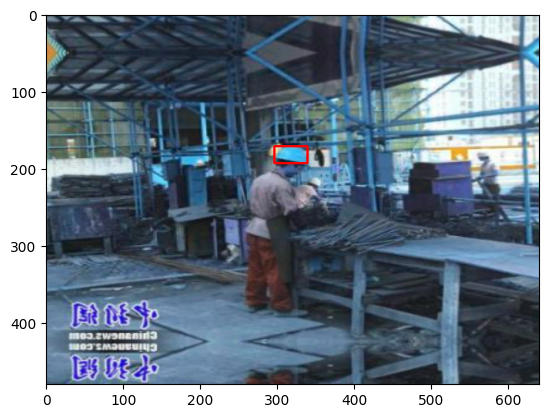

In [137]:
# plot the box round hard hat
cv2.rectangle(augmented_image_resized,
              (denormalized_coords[0], denormalized_coords[1]),
              (denormalized_coords[2], denormalized_coords[3]),
              (255, 0, 0), 2)

plt.imshow(augmented_image_resized)
plt.show()

# Run agumentation pipeline

In [143]:
# This code applys augmentation to each image so we have a big dataset

# directory for aug_data
aug_dir = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data'

# for loop through data splits
for partition in ['train','test','val']: 
    # read each folders images files
    for image in os.listdir(os.path.join(directory_path, partition, 'images')):
        img = cv2.imread(os.path.join(directory_path, partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        # if json file exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            # extract coord from json label
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            # normalise coords
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            # perfom data augmentation 60 times per image
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join(aug_dir, partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    # If there is no bounding box after augmentation, set the values to 0
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        # otherwise use box for augmented data
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    if label doesnt exisit set to 0
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                # save to new dir
                with open(os.path.join(aug_dir, partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

# Load images to tensorlfow datset

In [169]:
# Train images
train_aug_dir = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\train\images'
train_images = tf.data.Dataset.list_files(os.path.join(train_aug_dir, '*.jpg'), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [170]:
# Test images
test_aug_dir = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\test\images'
test_images = tf.data.Dataset.list_files(os.path.join(test_aug_dir, '*.jpg'), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [171]:
# Val images
val_aug_dir = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\val\images'
val_images = tf.data.Dataset.list_files(os.path.join(val_aug_dir, '*.jpg'), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [172]:
train_images.as_numpy_iterator().next()

array([[[3.11669149e-03, 1.06361054e-03, 5.27208846e-04],
        [2.68647447e-03, 6.01975713e-04, 1.16983974e-04],
        [2.71784072e-03, 5.70933335e-04, 1.74244138e-04],
        ...,
        [2.50562234e-03, 1.06372335e-03, 5.16938278e-04],
        [2.58407416e-03, 1.16239011e-03, 4.63362638e-04],
        [2.65244232e-03, 1.24484557e-03, 4.06705687e-04]],

       [[2.76668207e-03, 6.10494579e-04, 1.72520478e-04],
        [2.70003639e-03, 5.62371046e-04, 1.16653086e-04],
        [2.63259653e-03, 5.03461983e-04, 7.63357602e-05],
        ...,
        [2.82546901e-03, 1.55996834e-03, 7.40157033e-04],
        [2.56059878e-03, 1.17343361e-03, 3.77586082e-04],
        [2.37697107e-03, 8.35742161e-04, 7.89807527e-05]],

       [[2.67940969e-03, 5.47406904e-04, 1.17091222e-04],
        [2.69884197e-03, 5.45990246e-04, 1.30493529e-04],
        [2.68272660e-03, 5.34605177e-04, 1.16931915e-04],
        ...,
        [2.27441872e-03, 1.08327600e-03, 2.48222932e-04],
        [2.16438551e-03, 8.13